In [1]:
#-*- coding: utf-8 -*-

import tensorflow as tf
# dont display much info of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any level you prefer

# limit gpu memory usage only as much as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print("Setting memory growth to True for GPU: ", gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs: ", len(gpus), "Logical GPUs: ", len(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate, Add, AveragePooling2D
import numpy as np

import matplotlib.pyplot as plt


2024-01-05 15:18:53.531973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 15:18:54.113164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 15:18:54.113415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 15:18:54.208813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 15:18:54.398718: I tensorflow/core/platform/cpu_feature_guar

Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical GPUs:  1 Logical GPUs:  1


In [2]:

# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

#feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
#y = y[:, 0] #
# use laser power and velocity as labels
y = y[:, :2]
print("y shape: ", y.shape)

# print max of each column
print("max of each column: ", np.max(y, axis=0))
# normalize y by dividing laser power by max of each column
y = y / np.max(y, axis=0)


manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587, 2)
max of each column:  [2750   15]


In [3]:
# create a function to encode y
def encode_one_column(y):
    # create a new array of zeros with the same shape as y
    encoded_y = np.zeros(y.shape)
    # get the unique values in y
    unique_values = np.unique(y)
    # loop through the unique values
    for i, value in enumerate(unique_values):
        # find the indices where y equals the unique value
        indices = np.where(y == value)
        # set the indices in encoded_y to i
        encoded_y[indices] = i
    return encoded_y

# create new array to store encoded y
encoded_y = np.zeros(y.shape)
# loop through each column in y and encode it
for i in range(y.shape[1]):
    encoded_y[:, i] = encode_one_column(y[:, i])
    
# convert to int
encoded_y = encoded_y.astype(int)

In [4]:
# crate pairs
def create_pairs_2_labels(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    
    # define numclasses with the same columns as y_encoded
    numclasses = np.zeros(y_encoded.shape[1], dtype=int)
    idx = []

    for i in range(y_encoded.shape[1]):
        unique_values, unique_indices = np.unique(y_encoded[:, i], return_inverse=True)
        numclasses[i] = len(unique_values)
    
    
        #idx.append([np.where(unique_indices == j)[0] for j in range(numclasses[i])])
    
    # creade idx1 and idx2
    idx1 = [np.where(y_encoded==i)[0] for i in range(numclasses[0])]
    idx2  = [np.where(y_encoded==i)[0] for i in range(numclasses[1])]
        

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]
        p1 = label[0]
        v1 = label[1]
        p2 = np.random.choice(np.delete(np.arange(numclasses[0]), p1))
        v2 = np.random.choice(np.delete(np.arange(numclasses[1]), v1))

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(np.intersect1d(idx1[p1], idx2[v1])) #np.random.choice(idx[p1][v1])
        x11 = xiris[idxB]
        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, x11])
        labels.append([p1, v1, p1, v1])

        idxC = np.random.choice(np.intersect1d(idx1[p2], idx2[v1]))
        x21 = xiris[idxC]
        pairs.append([currentImage, x21])
        labels.append([p1, v1, p2, v1])
            
        idxD = np.random.choice(np.intersect1d(idx1[p1], idx2[v2]))
        x12 = xiris[idxD]
        pairs.append([currentImage, x12])
        labels.append([p1, v1, p1, v2])
        
        idxE = np.random.choice(np.intersect1d(idx1[p2], idx2[v2]))
        x22 = xiris[idxE]
        pairs.append([currentImage, x22])
        labels.append([p1, v1, p2, v2])
    

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels)       

                                                                                             
# create pairs
pairs, labels = create_pairs_2_labels(manta, xiris, encoded_y)
print("pairs shape: ", pairs.shape)
print("labels shape: ", labels.shape)

del manta, xiris, y, encoded_y

Creating pairs for image 0/9587, Completed 0%
Creating pairs for image 1000/9587, Completed 10%
Creating pairs for image 2000/9587, Completed 20%
Creating pairs for image 3000/9587, Completed 31%
Creating pairs for image 4000/9587, Completed 41%
Creating pairs for image 5000/9587, Completed 52%
Creating pairs for image 6000/9587, Completed 62%
Creating pairs for image 7000/9587, Completed 73%
Creating pairs for image 8000/9587, Completed 83%
Creating pairs for image 9000/9587, Completed 93%
pairs shape:  (38348, 2, 320, 320)
labels shape:  (38348, 4)


In [5]:
# define labels_2 when p1 and p2, v1 and v2 are the same
# label_2 has half of the number of columns of labels
labels_2 = np.zeros((labels.shape[0], int(labels.shape[1]/2)))
labels_2[:, 0] = labels[:, 0] == labels[:, 2]
labels_2[:, 1] = labels[:, 1] == labels[:, 3]
labels_2 = labels_2.astype(int)
print("labels_2 shape: ", labels_2.shape)


labels_2 shape:  (38348, 2)


In [6]:
# shuffle pairs and labels in the same order
# set seed
np.random.seed(42)
# get the indices
indices = np.arange(pairs.shape[0])
# shuffle indices
np.random.shuffle(indices)
# shuffle pairs and labels
pairs = pairs[indices]
labels = labels[indices]
labels_2 = labels_2[indices]

# split data into train and test
train_split = 0.8
# get the split index
split_idx = int(pairs.shape[0] * train_split)
# split the pairs and labels
X_train, X_test = pairs[:split_idx], pairs[split_idx:]
del pairs

y_train, y_test = labels[:split_idx], labels[split_idx:]
del labels

y_train_2, y_test_2 = labels_2[:split_idx], labels_2[split_idx:]
del labels_2
# delete pairs and labels
#del pairs, labels, labels_2


"""
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs, labels_2, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape} ",f"y_train shape: {y_train.shape} ")
print(f"X_test shape: {X_test.shape} ",f"y_test shape: {y_test.shape} ")
"""

'\n# split data into train and test\nfrom sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(pairs, labels_2, test_size=0.2, random_state=42, shuffle=True)\nprint(f"X_train shape: {X_train.shape} ",f"y_train shape: {y_train.shape} ")\nprint(f"X_test shape: {X_test.shape} ",f"y_test shape: {y_test.shape} ")\n'

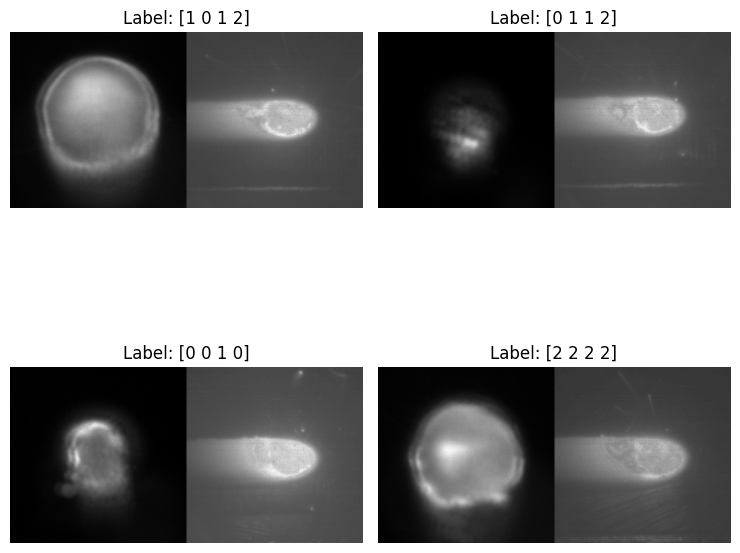

In [7]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.keras.layers.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# visualize pairs
visualize(X_train, y_train, to_show=4, num_col=2)

In [9]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)

    outputs = Dense(embedding_dim, activation='relu')(features)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
def contrastive_loss_with_margin(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        # Ensure that y_true is of type float32
        y_true = tf.cast(y_true, dtype=tf.float32)

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

def accuracy(y_true, y_pred):
    """
    Compute classification accuracy with a fixed threshold on distances.
    """
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, y_true.dtype)), tf.float32))

In [11]:
input_shape = (320, 320, 1)
embedding_dim= 128
batch_size = 64
epochs = 10
learning_rate = 0.0001


manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)
#encoder_with_projection_head.summary()

manta_encoded = encoder_with_projection_head(manta)
xiris_encoded = encoder_with_projection_head(xiris)


In [12]:
# Assuming encoded_l and encoded_r are your two input tensors
distance = tf.abs(manta_encoded - xiris_encoded)

output = tf.keras.layers.Dense(1, activation="linear")(distance)

siamese_net = tf.keras.Model(inputs=[manta, xiris], outputs=output)

siamese_net.compile(loss=contrastive_loss_with_margin(margin=1.0), 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), #optimizer=tf.keras.optimizers.RMSprop()
                    metrics=['accuracy']) # accuracy
siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 128)                  2492499   ['input_1[0][0]',             
                                                          2          'input_2[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 128)                  0         ['model_1[0][0]',       

In [13]:
history = siamese_net.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/10


2024-01-05 15:20:59.020488: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-05 15:20:59.443456: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-05 15:21:00.694545: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-05 15:21:03.366212: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0c0ce45960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-05 15:21:03.366282: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-05 15:21:03.399234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704468063.685541   58327 device_compiler.h:186] 

162/384 [===========>..................] - ETA: 13s - loss: -976743.5000 - accuracy: 0.2711

KeyboardInterrupt: 

1/1 [==============================] - 0s 393ms/step


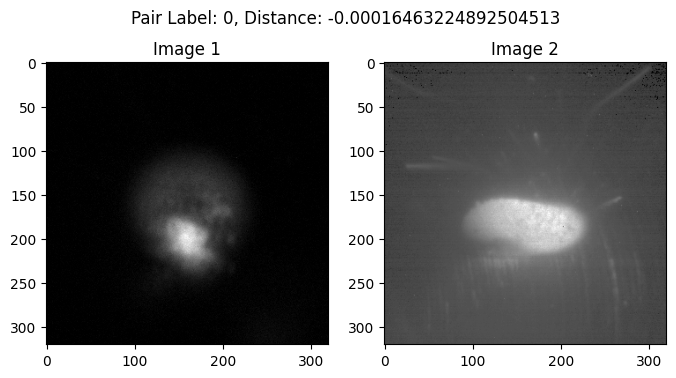

1/1 [==============================] - 0s 36ms/step


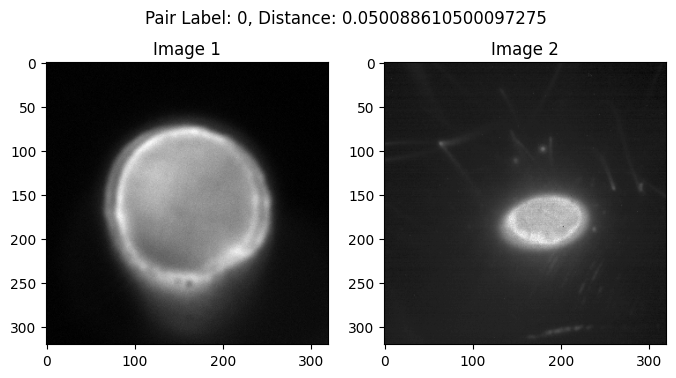

1/1 [==============================] - 0s 24ms/step


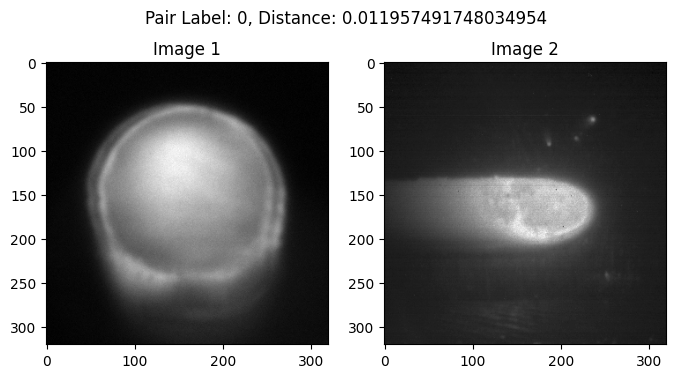

1/1 [==============================] - 0s 33ms/step


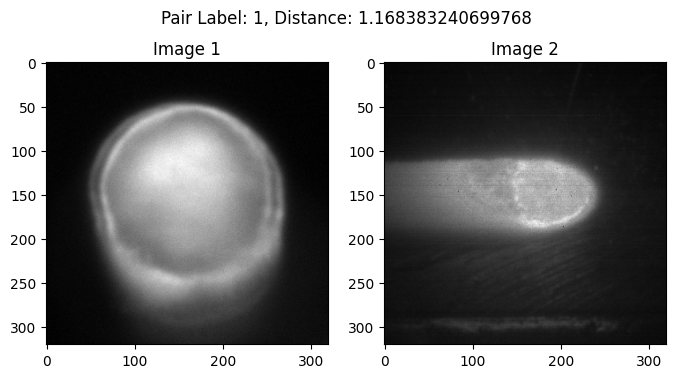

1/1 [==============================] - 0s 21ms/step


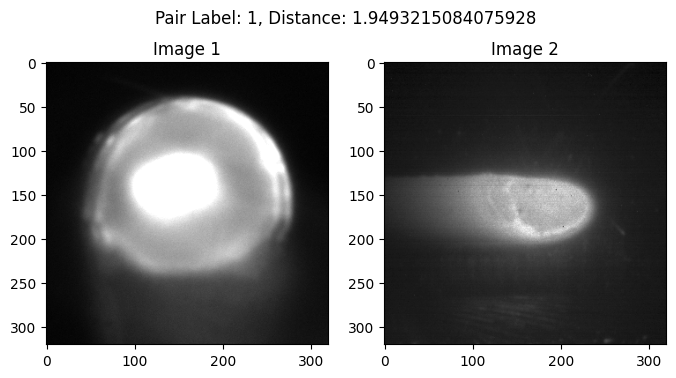

In [ ]:
# with X_test display 3 pairs and their distance
num_samples_to_verify = 5

for i in range(num_samples_to_verify):
    sample_idx = np.random.randint(0, len(X_test))
    pair = X_test[sample_idx]
    label = y_test[sample_idx]

    # Extract images from the pair
    image1, image2 = pair[0], pair[1]

    # Display images with their corresponding label
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    

    # Calculate the distance between the two images
    distance = siamese_net.predict([np.expand_dims(image1, axis=0), np.expand_dims(image2, axis=0)])[0][0]
    
    
    plt.suptitle(f"Pair Label: {label[0]}, Distance: {distance}")
    plt.show()

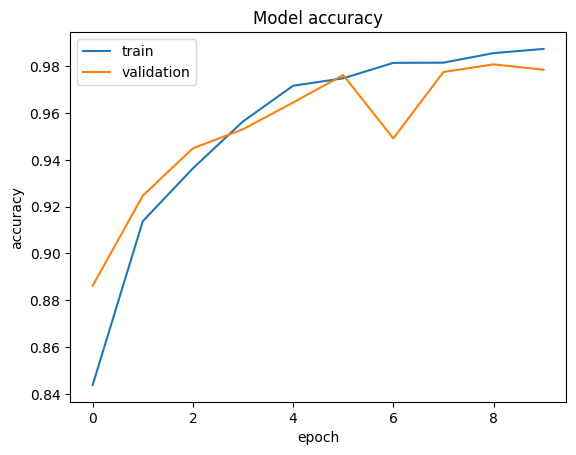

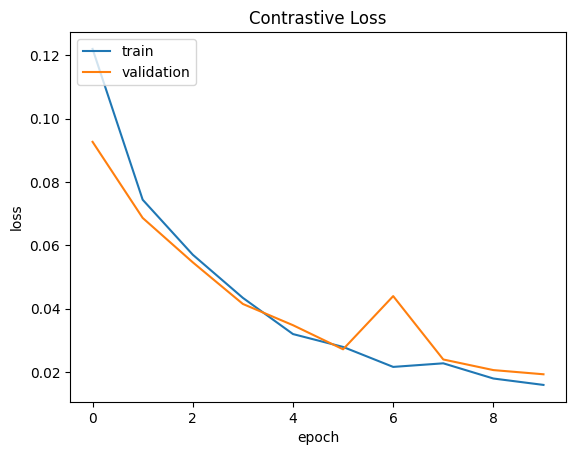

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")


In [ ]:
results = siamese_net.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print("test loss, test acc:", results)

120/120 [==============================] - 4s 24ms/step - loss: 0.0216 - accuracy: 0.9771
test loss, test acc: [0.021647656336426735, 0.9770534634590149]


120/120 [==============================] - 2s 15ms/step


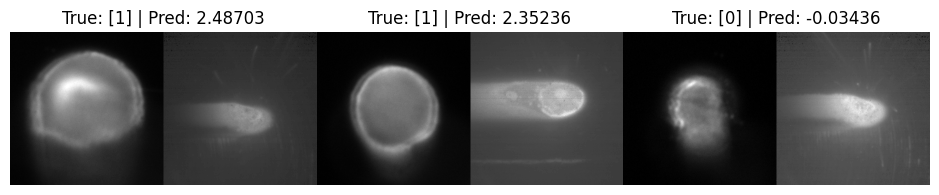

In [ ]:
predictions = siamese_net.predict([X_test[:, 0], X_test[:, 1]])
visualize(X_test, y_test, to_show=3, predictions=predictions, test=True)